In [210]:
from dataclasses import dataclass, field
from geopy.geocoders import Nominatim
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import time
import os
import json
import folium
from folium import plugins

from pyomo.environ import (
    ConcreteModel, Set, Param, Var, NonNegativeReals, NonNegativeIntegers,
    Objective, Constraint, Expression, Reals, minimize
)
from typing import Optional

In [211]:
data = pd.read_excel("data/interview problem.xlsx")

In [212]:
@dataclass
class RouteData:
    origins: list[str] = field(default_factory=list)
    od_pairs: list[tuple[str, str]] = field(default_factory=list)
    dist: dict[tuple[str, str], float] = field(default_factory=dict)
    demand: dict[tuple[str, str], float] = field(default_factory=dict)
    city_coords: dict[str, tuple[float, float]] = field(default_factory=dict)
    cache_file: str = "city_coords_cache.json"
    
    def __post_init__(self):
        # Initialize geolocator
        self.geolocator = Nominatim(user_agent="route_data_geocoder")
        # Load cache if exists
        if os.path.exists(self.cache_file):
            with open(self.cache_file, "r") as f:
                self.cache = json.load(f)
        else:
            self.cache = {}

    @classmethod
    def from_dataframe(cls, df: pd.DataFrame):
        df = df.rename(columns=str.strip)
        required_cols = {"Origin", "Destination", "Dist", "Demand"}
        if not required_cols.issubset(df.columns):
            raise ValueError(f"Missing columns: {required_cols - set(df.columns)}")
        
        origins = sorted(df["Origin"].unique().tolist())
        od_pairs = list(zip(df["Origin"], df["Destination"]))
        dist = {(row["Origin"], row["Destination"]): row["Dist"] for _, row in df.iterrows()}
        demand = {(row["Origin"], row["Destination"]): row["Demand"] for _, row in df.iterrows()}

        return cls(origins=origins, od_pairs=od_pairs, dist=dist, demand=demand)

    def _get_latlon(self, city: str) -> tuple[float, float]:
        """Geocode a city name using cache if available."""
        if city in self.cache:
            return tuple(self.cache[city])
        try:
            location = self.geolocator.geocode(city)
            if location:
                coords = (location.latitude, location.longitude)
                self.cache[city] = coords
                time.sleep(1)  # rate limit to avoid Nominatim blocking
                return coords
        except Exception:
            pass
        return (None, None)

    def prepare_coordinates(self, save_cache: bool = True) -> dict[str, tuple[float, float]]:
        """Fetch lat/lon for all cities in origins + destinations."""
        all_cities = sorted(set(self.origins + [d for _, d in self.od_pairs]))
        coords = {city: self._get_latlon(city) for city in tqdm(all_cities, desc="Geocoding cities")}
        self.city_coords = coords
        if save_cache:
            self._save_cache()
        return coords

    def _save_cache(self):
        with open(self.cache_file, "w") as f:
            json.dump(self.cache, f)

In [213]:
routes_data = RouteData.from_dataframe(data)
# Geocode all cities (uses cache to avoid repeated calls)
routes_data.prepare_coordinates()

Geocoding cities: 100%|█████████████████████| 10/10 [00:00<00:00, 285326.80it/s]


{'Chicago': (41.8755616, -87.6244212),
 'Dallas': (32.7762719, -96.7968559),
 'Houston': (29.7589382, -95.3676974),
 'Los Angeles': (34.0536909, -118.242766),
 'New York': (40.7127281, -74.0060152),
 'Philadelphia': (39.9527237, -75.1635262),
 'Phoenix': (33.4484367, -112.074141),
 'San Antonio': (29.4246002, -98.4951405),
 'San Diego': (32.7174202, -117.162772),
 'San Jose': (37.3361663, -121.890591)}

In [214]:
print(routes_data.origins)
print(routes_data.od_pairs)
print(routes_data.dist[("New York", "Chicago")])   # 713
print(routes_data.demand[("New York", "Chicago")]) # 8
print(routes_data.city_coords["New York"])

['Chicago', 'Dallas', 'Houston', 'Los Angeles', 'New York', 'Philadelphia', 'Phoenix', 'San Antonio', 'San Diego', 'San Jose']
[('New York', 'Los Angeles'), ('New York', 'Chicago'), ('New York', 'Houston'), ('New York', 'Phoenix'), ('New York', 'Philadelphia'), ('New York', 'San Antonio'), ('New York', 'San Diego'), ('New York', 'Dallas'), ('New York', 'San Jose'), ('Los Angeles', 'New York'), ('Los Angeles', 'Chicago'), ('Los Angeles', 'Houston'), ('Los Angeles', 'Phoenix'), ('Los Angeles', 'Philadelphia'), ('Los Angeles', 'San Antonio'), ('Los Angeles', 'San Diego'), ('Los Angeles', 'Dallas'), ('Los Angeles', 'San Jose'), ('Chicago', 'New York'), ('Chicago', 'Los Angeles'), ('Chicago', 'Houston'), ('Chicago', 'Phoenix'), ('Chicago', 'Philadelphia'), ('Chicago', 'San Antonio'), ('Chicago', 'San Diego'), ('Chicago', 'Dallas'), ('Chicago', 'San Jose'), ('Houston', 'New York'), ('Houston', 'Los Angeles'), ('Houston', 'Chicago'), ('Houston', 'Phoenix'), ('Houston', 'Philadelphia'), ('Hous

In [215]:
import folium
import pandas as pd

class RouteVisualizer:
    def __init__(self, route_data: RouteData):
        self.route_data = route_data

    def plot(self, save_path: str = "od_pairs_map.html"):
        """Generate interactive Folium map for OD pairs."""
        coords = self.route_data.city_coords
        if not coords:
            raise ValueError("City coordinates not loaded. Run route_data.prepare_coordinates() first.")

        # Build a DataFrame for plotting
        df = pd.DataFrame(
            [
                {
                    "Origin": i,
                    "Destination": j,
                    "Dist": self.route_data.dist[(i, j)],
                    "Demand": self.route_data.demand[(i, j)],
                    "Origin_lat": coords[i][0],
                    "Origin_lon": coords[i][1],
                    "Dest_lat": coords[j][0],
                    "Dest_lon": coords[j][1],
                }
                for (i, j) in self.route_data.od_pairs
                if coords[i][0] is not None and coords[j][0] is not None
            ]
        )

        # Center map
        center_lat = df[["Origin_lat", "Dest_lat"]].mean().mean()
        center_lon = df[["Origin_lon", "Dest_lon"]].mean().mean()
        m = folium.Map(location=[center_lat, center_lon], zoom_start=4, tiles="cartodb positron")

        # Add OD lines
        for _, row in df.iterrows():
            folium.PolyLine(
                [(row["Origin_lat"], row["Origin_lon"]),
                 (row["Dest_lat"], row["Dest_lon"])],
                color="blue" if row["Demand"] > 0 else "gray",
                weight=0.2 + row["Demand"] / 2,
                opacity=0.6,
            ).add_to(m)

        # Add city markers with small font labels
        for city, (lat, lon) in coords.items():
            if lat is not None:
                # Circle marker
                folium.CircleMarker(
                    [lat, lon],
                    radius=4,
                    color="red",
                    fill=True,
                    fill_opacity=0.8,
                ).add_to(m)
                # Small font label (HTML overlay)
                folium.map.Marker(
                    [lat, lon],
                    icon=folium.DivIcon(
                        html=f"""<div style="font-size:9px; color:#222; text-align:center;">{city}</div>"""
                    ),
                ).add_to(m)

        m.save(save_path)
        print(f"Map saved to {save_path}")
        return m

In [216]:
viz = RouteVisualizer(routes_data)

m = viz.plot("od_routes.html")
m  # Shows inline in Jupyter

Map saved to od_routes.html


# Model formulation
## Terminolology
* Equipment/trailer: 1 load exactly fills one trailer
* Load: a shipment that can fill one trailer
* own-fleet (own): Fedex owned tractor and trailors. Cost \$2/mile for any move (loaded or empty)
* Purchased motor (pm): #PL carrier using their tractor and trailers. Cost \$3/mile for any move but can change in the future
* Trip: 1 movement of a trailer from origin to destination. A loaded trip (own) carries 1 load, Empty repositioning may be required for empty own equipment, purchased motor trip hauls load  but does not involve Fedex trailers.
## Input
### Sets
### Parameters
### Decision variables
* $x_{ij}^{own}$--number of own fleet loaded trips from $i$ to $j$. How many of our own trailers carry loads from $i$ to $j$.
*  $x_{ij}^{pm}$--number of purchased motor trips from $i$ to $j$. How many loads are oursourced from $i$ to $j$.
*  $y_{ij}$-- Number of empty reposition trips from $i$ to $j$. How many empty trailors you tow from $i$ to $j$.

In [217]:
def build_model(
    raw_routes: RouteData,               
    c_own: float = 2.0,
    c_pm: float = 3.0,
    integer: bool = False,
    r_target: Optional[float] = None
):
    """
    Build a Pyomo model for fleet allocation using a RouteData object.

    Args:
        raw_routes: RouteData
            Dataclass containing:
                - origins (list of city names)
                - od_pairs (list of (origin, destination))
                - dist (dict {(i,j): distance})
                - demand (dict {(i,j): loads})
        c_own: float
            Cost $ per mile for own fleet.
        c_pm: float
            Cost $ per mile for purchased motor.
        integer: bool
            If True, restricts trip counts to integers.
        r_target: float or None
            Optional empty-mile ratio upper bound (e.g., 0.2 means ≤ 20%).

    Returns:
        A fully constructed Pyomo ConcreteModel.
    """

    # Extract route data
    node_list = list(raw_routes.origins)
    arc_list = list(raw_routes.od_pairs)
    dist_ij = dict(raw_routes.dist)
    Delta_ij = dict(raw_routes.demand)

    # Build Model
    m = ConcreteModel()

    # Sets
    m.N = Set(initialize=node_list)

    # Only arcs with distances defined
    A_clean = [(i, j) for (i, j) in arc_list if (i, j) in dist_ij]
    m.A = Set(dimen=2, initialize=A_clean)

    # Demand arcs (where Delta_ij > 0)
    # considering only demand arcs wirth demand > 0 can lead to cases where there is load but with no demand
    #m.Ad = Set(
    #    dimen=2,
    #    initialize=[(i, j) for (i, j) in A_clean if float(Delta_ij.get((i, j), 0.0)) > 0.0],
    #)

    m.Ad = Set(
        dimen=2,
        initialize=[(i, j) for (i, j) in A_clean],
    )

    # Params
    def dist_init(m_, i, j):
        return float(dist_ij[(i, j)])
    m.d = Param(m.A, initialize=dist_init, within=Reals)

    def Delta_init(m_, i, j):
        return float(Delta_ij.get((i, j), 0.0))
    m.Delta = Param(m.A, initialize=Delta_init, within=Reals)

    m.c_own = Param(initialize=float(c_own))
    m.c_pm = Param(initialize=float(c_pm))

    # Variables
    Dom = NonNegativeIntegers if integer else NonNegativeReals
    m.x_own = Var(m.A, domain=Dom)  # loaded trips served by own fleet
    m.x_pm = Var(m.A, domain=Dom)   # loaded trips by purchased motor
    m.y = Var(m.A, domain=Dom)      # empty reposition trips

    # Shipment satisfaction (only where demand exists)
    def ship_sat_rule(m_, i, j):
        if (i, j) in m_.Ad:
            return m_.x_own[i, j] + m_.x_pm[i, j] == m_.Delta[i, j]
        else:
            return Constraint.Skip
    m.ShipSat = Constraint(m.A, rule=ship_sat_rule)

    # Empty-trailer balance per node
    def empty_balance_rule(m_, i):
        inbound_loaded = sum(m_.x_own[p, q] for (p, q) in m_.A if q == i)
        inbound_empty = sum(m_.y[p, q] for (p, q) in m_.A if q == i)
        outbound_loaded = sum(m_.x_own[p, q] for (p, q) in m_.A if p == i)
        outbound_empty = sum(m_.y[p, q] for (p, q) in m_.A if p == i)
        return inbound_loaded + inbound_empty == outbound_loaded + outbound_empty
    m.EmptyBal = Constraint(m.N, rule=empty_balance_rule)

    # --- Expressions ---
    m.M_loaded = Expression(expr=sum(m.d[i, j] * m.x_own[i, j] for (i, j) in m.A))
    m.M_empty = Expression(expr=sum(m.d[i, j] * m.y[i, j] for (i, j) in m.A))
    m.M_pm = Expression(expr=sum(m.d[i, j] * m.x_pm[i, j] for (i, j) in m.A))

    # --- Objective ---
    m.TotalCost = Objective(
        expr=m.c_own * (m.M_loaded + m.M_empty) + m.c_pm * m.M_pm,
        sense=minimize
    )

    if (r_target is not None) and (0.0 <= float(r_target) < 1.0):
        ratio_coeff = r_target / (1.0 - r_target)
        m.EmptyRatio = Constraint(expr=m.M_empty <= ratio_coeff * m.M_loaded)

    return m

def solve_model(m, solver_name="highs", tee=True):
    from pyomo.contrib.appsi.solvers import Highs
    solver = SolverFactory(solver_name)
    result = solver.solve(m, tee=tee)
    print(f"Status: {result.solver.status}, Termination: {result.solver.termination_condition}")
    print(f"Objective (TotalCost): {m.TotalCost():,.2f}")
    return result

In [218]:
model = build_model(
    raw_routes=routes_data,
    c_own=2.0,
    c_pm=3.0,
    integer=False,
    r_target=0.20
)

In [219]:
res = solve_model(model, solver_name="highs", tee=True)

Status: ok, Termination: optimal
Objective (TotalCost): 844,380.00


## Solution Data

In [220]:
from pyomo.environ import value

@dataclass
class SolutionDiagnostics:
    """Extracts and summarizes results from a solved Pyomo model."""

    model: object
    routes: object  # RouteData instance

    def summarize_od_flows(self) -> pd.DataFrame:
        """Return OD-level summary of demand, fleet allocation, and costs."""
        m = self.model
        data = []
        for (i, j) in m.A:
            demand = value(m.Delta[i, j])
            x_own = value(m.x_own[i, j])
            x_pm = value(m.x_pm[i, j])
            y = value(m.y[i, j])
            dist = value(m.d[i, j])

            own_loaded_cost = dist * x_own * value(m.c_own)
            pm_cost = dist * x_pm * value(m.c_pm)
            empty_cost = dist * y * value(m.c_own)

            data.append({
                "Origin": i,
                "Destination": j,
                "Distance": dist,
                "Demand": demand,
                "OwnFleet_Loaded": x_own,
                "PurchasedMotor": x_pm,
                "Empty_Reposition": y,
                "OwnFleet_Loaded_Cost": own_loaded_cost,
                "PurchasedMotor_Cost": pm_cost,
                "Empty_Cost": empty_cost,
                "Total_Cost": own_loaded_cost + pm_cost + empty_cost
            })
        df = pd.DataFrame(data)
        df["Demand_Satisfied"] = (df["OwnFleet_Loaded"] + df["PurchasedMotor"]).round(5) == df["Demand"].round(5)
        return df

    def check_empty_balance(self) -> pd.DataFrame:
        """Verify empty balance for each node and include inbound/outbound total demand."""
        m = self.model
        records = []
        for i in m.N:
            inbound_loaded = sum(value(m.x_own[p, q]) for (p, q) in m.A if q == i)
            inbound_empty = sum(value(m.y[p, q]) for (p, q) in m.A if q == i)
            outbound_loaded = sum(value(m.x_own[p, q]) for (p, q) in m.A if p == i)
            outbound_empty = sum(value(m.y[p, q]) for (p, q) in m.A if p == i)
    
            lhs = inbound_loaded + inbound_empty
            rhs = outbound_loaded + outbound_empty
            balance_ok = abs(lhs - rhs) < 1e-5
    
            # Compute inbound and outbound demand totals
            inbound_demand = sum(value(m.Delta[p, q]) for (p, q) in m.A if q == i)
            outbound_demand = sum(value(m.Delta[p, q]) for (p, q) in m.A if p == i)
    
            records.append({
                "Node": i,
                "Inbound_Loaded": inbound_loaded,
                "Inbound_Empty": inbound_empty,
                "Outbound_Loaded": outbound_loaded,
                "Outbound_Empty": outbound_empty,
                "LHS (Inbound)": lhs,
                "RHS (Outbound)": rhs,
                "Balance_OK": balance_ok,
                "Inbound_Total_Demand": inbound_demand,
                "Outbound_Total_Demand": outbound_demand
            })
        return pd.DataFrame(records)

    def compute_mileage_summary(self) -> dict:
        """Compute total and percentage empty miles."""
        m = self.model
        M_loaded = value(m.M_loaded)
        M_empty = value(m.M_empty)
        M_pm = value(m.M_pm)

        total_own_miles = M_loaded + M_empty
        empty_pct = (M_empty / total_own_miles) * 100 if total_own_miles > 0 else 0.0

        return {
            "OwnFleet_Loaded_Miles": M_loaded,
            "OwnFleet_Empty_Miles": M_empty,
            "PurchasedMotor_Miles": M_pm,
            "Total_OwnFleet_Miles": total_own_miles,
            "Empty_Mile_Percent": empty_pct,
            "Total_System_Miles": total_own_miles + M_pm,
            "Total_Cost": value(m.TotalCost)
        }

    def run_cpm_sensitivity(
        self,
        c_pm_range=None,
        c_own=None,
        integer=False,
        r_target=None,
        solver_name="highs",
        verbose=False
    ) -> pd.DataFrame:
        """
        Runs sensitivity analysis for purchased motor cost (c_pm).

        Returns:
            pd.DataFrame summarizing:
                - c_pm
                - Total cost
                - Own loaded cost
                - Own empty cost
                - Purchased motor cost
                - Empty mile %
        """
        if c_pm_range is None:
            c_pm_range = np.linspace(2.0, 5.0, 10)

        if c_own is None:
            c_own = value(self.model.c_own)

        results = []
        solver = SolverFactory(solver_name)

        for c_pm in c_pm_range:
            # Build model with current c_pm
            model = build_model(
                raw_routes=self.routes,
                c_own=c_own,
                c_pm=c_pm,
                integer=integer,
                r_target=r_target
            )

            solver.solve(model, tee=verbose)

            diag = SolutionDiagnostics(model, self.routes)
            summary = diag.compute_mileage_summary()

            total_miles = summary["Total_System_Miles"]
            empty_miles = summary["OwnFleet_Empty_Miles"]
            empty_pct_total = (empty_miles / total_miles) * 100 if total_miles > 0 else 0.0

            results.append({
                "c_pm": c_pm,
                "Total_Cost": summary["Total_Cost"],
                "OwnFleet_Loaded_Cost": summary["OwnFleet_Loaded_Miles"] * c_own,
                "OwnFleet_Empty_Cost": summary["OwnFleet_Empty_Miles"] * c_own,
                "PurchasedMotor_Cost": summary["PurchasedMotor_Miles"] * c_pm,
                "Empty_Mile_Percent_Total": round(empty_pct_total, 2)
            })

        return pd.DataFrame(results)

In [221]:
diag = SolutionDiagnostics(model, routes_data)

In [222]:
# OD summary
df_flows = diag.summarize_od_flows()
df_flows[df_flows.Demand_Satisfied == False]

,Origin,Destination,Distance,Demand,OwnFleet_Loaded,PurchasedMotor,Empty_Reposition,OwnFleet_Loaded_Cost,PurchasedMotor_Cost,Empty_Cost,Total_Cost,Demand_Satisfied


In [223]:
df_flows

,Origin,Destination,Distance,Demand,OwnFleet_Loaded,PurchasedMotor,Empty_Reposition,OwnFleet_Loaded_Cost,PurchasedMotor_Cost,Empty_Cost,Total_Cost,Demand_Satisfied
0,New York,Los Angeles,2550.0,10.0,10.0,0.0,0.0,51000.0,0.0,0.0,51000.0,True
1,New York,Chicago,713.0,8.0,8.0,0.0,0.0,11408.0,0.0,0.0,11408.0,True
2,New York,Houston,1416.0,6.0,6.0,0.0,0.0,16992.0,0.0,0.0,16992.0,True
3,New York,Phoenix,2145.0,5.0,5.0,0.0,0.0,21450.0,0.0,0.0,21450.0,True
4,New York,Philadelphia,95.0,0.0,-0.0,0.0,4.0,-0.0,0.0,760.0,760.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
85,San Jose,Phoenix,650.0,1.0,1.0,0.0,0.0,1300.0,0.0,0.0,1300.0,True
86,San Jose,Philadelphia,2580.0,1.0,1.0,0.0,0.0,5160.0,0.0,0.0,5160.0,True
87,San Jose,San Antonio,1730.0,1.0,1.0,0.0,0.0,3460.0,0.0,0.0,3460.0,True
88,San Jose,San Diego,460.0,1.0,1.0,0.0,0.0,920.0,0.0,0.0,920.0,True


In [224]:
# Balance check
df_balance = diag.check_empty_balance()
df_balance

,Node,Inbound_Loaded,Inbound_Empty,Outbound_Loaded,Outbound_Empty,LHS (Inbound),RHS (Outbound),Balance_OK,Inbound_Total_Demand,Outbound_Total_Demand
0,Chicago,24.0,0.0,24.0,0.0,24.0,24.0,True,33.0,30.0
1,Dallas,13.0,0.0,13.0,0.0,13.0,13.0,True,16.0,14.0
2,Houston,25.0,0.0,25.0,0.0,25.0,25.0,True,28.0,25.0
3,Los Angeles,42.0,0.0,42.0,0.0,42.0,42.0,True,42.0,67.0
4,New York,52.0,0.0,48.0,4.0,52.0,52.0,True,59.0,48.0
5,Philadelphia,15.0,4.0,19.0,0.0,19.0,19.0,True,15.0,20.0
6,Phoenix,17.0,0.0,17.0,0.0,17.0,17.0,True,20.0,17.0
7,San Antonio,14.0,0.0,14.0,0.0,14.0,14.0,True,17.0,15.0
8,San Diego,13.0,0.0,13.0,0.0,13.0,13.0,True,17.0,15.0
9,San Jose,11.0,0.0,11.0,0.0,11.0,11.0,True,15.0,11.0


In [225]:
# Mileage and cost summary
summary = diag.compute_mileage_summary()
for k, v in summary.items():
    print(f"{k:25s}: {v:,.2f}")

OwnFleet_Loaded_Miles    : 373,360.00
OwnFleet_Empty_Miles     : 380.00
PurchasedMotor_Miles     : 32,300.00
Total_OwnFleet_Miles     : 373,740.00
Empty_Mile_Percent       : 0.10
Total_System_Miles       : 406,040.00
Total_Cost               : 844,380.00


## Sensitivity Analysis--cost

In [154]:
def plot_cost_sensitivity(sensitivity_df):
    """
    Plots cost vs c_pm with empty-mile % as labels.
    sensitivity_df: DataFrame from run_cpm_sensitivity
    """
    plt.figure(figsize=(10,6))

    x = sensitivity_df["c_pm"]
    
    # Plot lines
    plt.plot(x, sensitivity_df["OwnFleet_Loaded_Cost"] + sensitivity_df["OwnFleet_Empty_Cost"], 
             marker='o', label="Own Fleet Cost", color='blue', linewidth=1)
    plt.plot(x, sensitivity_df["PurchasedMotor_Cost"], 
             marker='o', label="Purchased Motor Cost", color='orange', linewidth=1)
    plt.plot(x, sensitivity_df["Total_Cost"], 
             marker='o', label="Total Cost", color='green', linewidth=3)

    # Annotate empty mile %
    for i, val in enumerate(sensitivity_df["Empty_Mile_Percent_Total"]):
        plt.text(x[i], sensitivity_df["Total_Cost"][i]*1.01, f"{val:.1f}%", 
                 ha='center', va='bottom', fontsize=9, color='red')

    plt.xlabel("Purchased Motor Cost ($/mile)")
    plt.ylabel("Cost ($)")
    plt.title("Cost Sensitivity to Purchased Motor Price (empty mile percentage in red)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Format y-axis with commas
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    plt.tight_layout()
    plt.show()

In [192]:
c_pm_values = np.arange(3.0, 6.5, 0.5)  # $3.0 → $6.0
sensitivity_df = diag.run_cpm_sensitivity(
    c_pm_range=c_pm_values,
    c_own=2.0,
    integer=False,
    r_target=0.2, # currently 20%
    solver_name="highs",
    verbose=False
)

sensitivity_df

,c_pm,Total_Cost,OwnFleet_Loaded_Cost,OwnFleet_Empty_Cost,PurchasedMotor_Cost,Empty_Mile_Percent_Total
0,3.0,844380.0,746720.0,760.0,96900.0,0.09
1,3.5,860336.5,748410.0,1834.0,110092.5,0.23
2,4.0,875940.0,799850.0,53150.0,22940.0,6.15
3,4.5,875940.0,811320.0,64620.0,0.0,7.38
4,5.0,875940.0,811320.0,64620.0,0.0,7.38
5,5.5,875940.0,811320.0,64620.0,0.0,7.38
6,6.0,875940.0,811320.0,64620.0,0.0,7.38


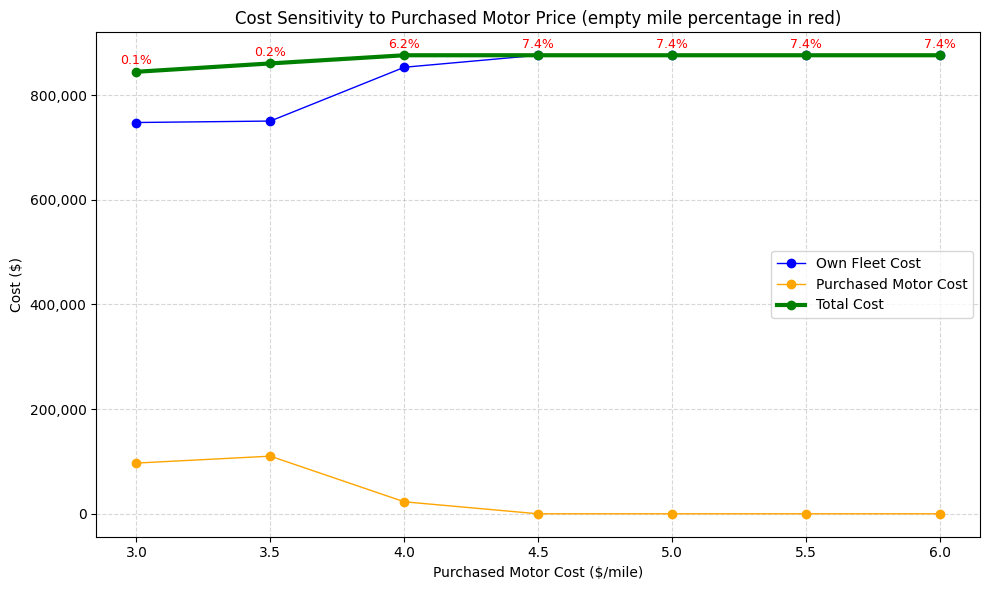

In [193]:
plot_cost_sensitivity(sensitivity_df)

# Solution Visualizations

In [226]:
import folium
from IPython.display import display
import math

class ResultVisualizer:
    def __init__(self, routes: RouteData, diag: SolutionDiagnostics):
        self.routes = routes
        self.diag = diag

    def plot_cost_sensitivity(self, df_sensitivity: pd.DataFrame, save_path=None):
        """
        Plots cost vs c_pm with empty-mile % as labels.
        sensitivity_df: DataFrame from run_cpm_sensitivity
        """
        plt.figure(figsize=(10,6))
    
        x = sensitivity_df["c_pm"]
        
        # Plot lines
        plt.plot(x, sensitivity_df["OwnFleet_Loaded_Cost"] + sensitivity_df["OwnFleet_Empty_Cost"], 
                 marker='o', label="Own Fleet Cost", color='blue', linewidth=1)
        plt.plot(x, sensitivity_df["PurchasedMotor_Cost"], 
                 marker='o', label="Purchased Motor Cost", color='orange', linewidth=1)
        plt.plot(x, sensitivity_df["Total_Cost"], 
                 marker='o', label="Total Cost", color='green', linewidth=3)
    
        # Annotate empty mile %
        for i, val in enumerate(sensitivity_df["Empty_Mile_Percent_Total"]):
            plt.text(x[i], sensitivity_df["Total_Cost"][i]*1.01, f"{val:.1f}%", 
                     ha='center', va='bottom', fontsize=9, color='red')
    
        plt.xlabel("Purchased Motor Cost ($/mile)")
        plt.ylabel("Cost ($)")
        plt.title("Cost Sensitivity to Purchased Motor Price (empty mile percentage in red)")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
    
        # Format y-axis with commas
        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
        plt.show()

    def create_route_map(self, diag: SolutionDiagnostics, trip_type="OwnFleet_Loaded"):
        """
        Generate a map for a single trip_type
        """
        if not self.routes.city_coords:
            raise ValueError("City coordinates not loaded. Run routes.prepare_coordinates() first.")

        # Center map at average city coordinates
        all_coords = list(self.routes.city_coords.values())
        lat_center = sum(lat for lat, lon in all_coords) / len(all_coords)
        lon_center = sum(lon for lat, lon in all_coords) / len(all_coords)
        m = folium.Map(location=[lat_center, lon_center], zoom_start=4, tiles="cartodb positron")

        df = diag.summarize_od_flows()
        col_map = {
            "OwnFleet_Loaded": "OwnFleet_Loaded",
            "PurchasedMotor": "PurchasedMotor",
            "Empty_Reposition": "Empty_Reposition"
        }
        df_plot = df[df[col_map[trip_type]] > 0]

        color_map = {
            "OwnFleet_Loaded": "blue",
             "PurchasedMotor": "orange",
            "Empty_Reposition": "red"
        }

        for _, row in df_plot.iterrows():
            origin = self.routes.city_coords.get(row["Origin"])
            dest = self.routes.city_coords.get(row["Destination"])
            if origin is None or dest is None:
                continue
            trips = row[col_map[trip_type]]
            folium.PolyLine(
                locations=[origin, dest],
                color=color_map[trip_type],
                weight=2 + trips*0.2,
                tooltip=f"{row['Origin']} → {row['Destination']}: {trips:.0f} trips",
                opacity=0.7
            ).add_to(m)

        # Add city markers with small labels
        for city, coord in self.routes.city_coords.items():
            folium.CircleMarker(
                location=coord,
                radius=4,
                color="black",
                fill=True,
                fill_color="gray",
                fill_opacity=0.7,
            ).add_to(m)
            folium.map.Marker(
                location=coord,
                icon=folium.DivIcon(
                    html=f"""<div style="font-size:9px; color:#222; text-align:center;">{city}</div>"""
                )
            ).add_to(m)
        return m

    # --------------------------
    # Multi-map grid for multiple c_pm values
    # --------------------------
    def plot_od_maps_grid(self, c_pm_values, trip_types=["OwnFleet_Loaded", "PurchasedMotor", "Empty_Reposition"]):
        """
        Returns dictionary of folium maps organized as maps_dict[c_pm][trip_type]
        """
        maps_dict = {}
        for cpm in c_pm_values:
            # Build and solve model
            model = build_model(
                raw_routes=self.routes,
                c_own=value(self.diag.model.c_own),
                c_pm=cpm,
                integer=False,
                r_target=0.2
            )
            solver = SolverFactory("highs")
            solver.solve(model, tee=False)
            diag_new = SolutionDiagnostics(model, self.routes)

            maps_dict[cpm] = {}
            for trip in trip_types:
                maps_dict[cpm][trip] = self.create_route_map(diag_new, trip_type=trip)
        return maps_dict

    def display_maps_grid(self, maps_dict, c_pm_values=None, trip_types=None, map_width="33%", map_height="400"):
        """
        Display multiple folium maps in Jupyter as a grid of iframes.
        maps_dict[c_pm][trip_type] should be precomputed using plot_od_maps_grid.
        """
        if c_pm_values is None:
            c_pm_values = sorted(maps_dict.keys())
        if trip_types is None:
            # take trip types from first c_pm
            trip_types = sorted(maps_dict[c_pm_values[0]].keys())

        for cpm in c_pm_values:
            display(HTML(f"<h3>Purchased Motor Cost = {cpm}</h3>"))
            row_html = ""
            for trip in trip_types:
                m = maps_dict[cpm][trip]
                # Ensure folder exists
                map_filename = f"map_{cpm}_{trip}.html"
                m.save(map_filename)
                row_html += f'<iframe src="{map_filename}" width="{map_width}" height="{map_height}"></iframe>'
            display(HTML(row_html))

In [227]:
# Sensitivity visuals
df_sens = diag.run_cpm_sensitivity(c_pm_range=[3,4,5])
viz = ResultVisualizer(routes_data, diag)

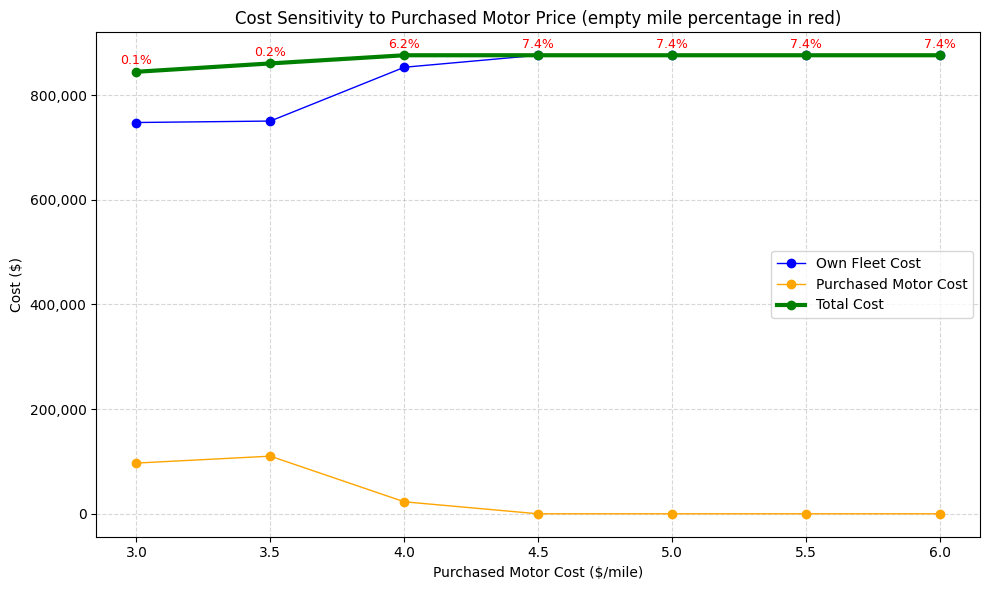

In [228]:
# Plot cost vs c_pm
viz.plot_cost_sensitivity(df_sens)

In [229]:
# Generate maps for multiple c_pm values
maps_dict = viz.plot_od_maps_grid(c_pm_values=[3,4,5])

In [230]:
# Display a single map in Jupyter
maps_dict[3]["OwnFleet_Loaded"]

In [231]:
viz.display_maps_grid(maps_dict, c_pm_values=[3,4,5], trip_types=["OwnFleet_Loaded","PurchasedMotor","Empty_Reposition"])

/Users/alankinene/.cache/uv/archive-v0/ZNDd4fg7xZMN86wwDeVun/lib/python3.13/site-packages/IPython/core/display.py:447: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
